# Homework 1 - FE 621 - Waldyr Faustini

## Part 1 - Getting Data Using Yahoo Finance

I will use the yfinance API, not an official Yahoo API but i think was the best solution in this case

In [1]:
# pip install yfinance --upgrade --no-cache-dir

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm

pd.options.mode.chained_assignment = None  # default='warn'

tqdm.pandas() # for progress bars

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Bonus
Create a program that is capable of downloading multiple assets, combine them with the associated time column, and save the data into a csv or excel file.

Since we intend on only downloading data after market close, it is sufficient for us to download equity data only for close values. However, in the last part of this exercise we also explicitly get intraday data for the specified tickers, for completeness.

#### First we show how the code works for AAPL as an example

In [3]:
def download_current_options(ticker: yf.Ticker, savepath=None):
    
    download_datetime = pd.to_datetime('now')
    download_date = download_datetime.date().strftime('%Y-%m-%d')
    
    option_list = []
    for maturity in ticker.options:
        
        # only download for the upcoming weeks, not including this one
        # this will bug for dates later in the year, but work now
        if (pd.to_datetime(maturity).week <= download_datetime.week):
            pass
        else:
            calls = ticker.option_chain(maturity).calls
            puts = ticker.option_chain(maturity).puts

            calls['type'] = 'call'
            puts['type'] = 'put'
            df = pd.concat([calls, puts])

            df['maturity'] = maturity
            option_list.append(df)

    options = pd.concat(option_list)
    options['download_date'] = download_date
    options['ticker_underlying'] = ticker.ticker
    
    if savepath:
        options.to_csv(savepath)
        print(f"{ticker.ticker} options:\tsaved to {savepath}")
    
    return options

In [4]:
def download_equity_data(ticker: yf.Ticker, savepath=None):
    
    download_datetime = pd.to_datetime('now')
    download_date = download_datetime.date().strftime('%Y-%m-%d')
    
    hist = ticker.history(period='1d').tail(1)
    hist['ticker'] = ticker.ticker
    hist['download_date'] = download_date
    if savepath:
        hist.to_csv(savepath)
        print(f"{ticker.ticker} market data:\tsaved to {savepath}")
        
    return hist

In [5]:
def download_ticker_full_data(ticker_str):
    ticker = yf.Ticker(ticker_str)
    download_datetime = pd.to_datetime('now')
    filename = lambda x: f"{ticker.ticker}__{x}_{download_datetime.strftime('%Y-%m-%d')}.csv"
    option_file = filename('options')
    equity_file = filename('equity')
    hist, opts = download_equity_data(ticker, savepath=equity_file), download_current_options(ticker, savepath=option_file)
    return hist, opts

In [63]:
%%time
hist, opts = download_ticker_full_data('AAPL')

AAPL market data: saved to AAPL__equity_2021-02-22.csv
AAPL options: saved to AAPL__options_2021-02-22.csv
Wall time: 23.5 s


Visualize AAPL data and options:

In [64]:
hist.head(3) # there is by construction just one value - the last recorded close

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,download_date
Date,,,,,,,,,
2021-02-19,130.240005,130.710007,128.800003,129.869995,87668834,0,0,AAPL,2021-02-22


In [65]:
opts.head(3)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,type,maturity,download_date,ticker_underlying
0,AAPL210305C00070000,2021-02-19 20:55:11,70.0,60.00,0.0,0.0,0.0,0.0,3.0,4.0,0.00001,True,REGULAR,USD,call,2021-03-05,2021-02-22,AAPL
1,AAPL210305C00075000,2021-02-11 15:12:01,75.0,60.25,0.0,0.0,0.0,0.0,3.0,3.0,0.00001,True,REGULAR,USD,call,2021-03-05,2021-02-22,AAPL
2,AAPL210305C00080000,2021-02-08 20:24:00,80.0,56.40,0.0,0.0,0.0,0.0,2.0,1.0,0.00001,True,REGULAR,USD,call,2021-03-05,2021-02-22,AAPL


We now proceed to formalize this into a single script for a list of tickers

In [81]:
def download_list_ticker_data(tickers: list):
    assert tickers, "Ticker list is empty"
    
    hist_list, opts_list = [], []
    for ticker in tickers:
        hist, opts = download_ticker_full_data(ticker)
        hist_list.append(hist)
        opts_list.append(opts)
        
    hist_df = pd.concat(hist_list)
    opts_df = pd.concat(opts_list)
    
    # pre-process
    len_opts = len(opts_df)
    opts_df = opts_df.dropna()
    opts_df = opts_df.drop_duplicates()
    print(f"After dropping NAs and duplicates, options data went from {len_opts} to {len(opts)} entries")
    
    filename = lambda x: f"{' '.join(tickers)}__{x}_{pd.to_datetime('now').strftime('%Y-%m-%d')}.csv"
    hist_df.to_csv(filename('equity'))
    opts_df.to_csv(filename('options'))
    
    return hist_df, opts_df

In [83]:
%%time
hist, opts = download_list_ticker_data(['SPY', "^VIX", "AAPL"])

SPY market data:	saved to SPY__equity_2021-02-22.csv
SPY options:	saved to SPY__options_2021-02-22.csv
^VIX market data:	saved to ^VIX__equity_2021-02-22.csv
^VIX options:	saved to ^VIX__options_2021-02-22.csv
AAPL market data:	saved to AAPL__equity_2021-02-22.csv
AAPL options:	saved to AAPL__options_2021-02-22.csv
After dropping NAs and duplicates, options data went from 9329 to 2083 entries
Wall time: 1min 18s


### Bonus: intraday equity data with a single time index

To pick data only for days Feb 23 and 24, we use the Yahoo finance API and clean data afterwards

In [112]:
bonus_data = yf.download("AMZN SPY ^VIX", start="2021-02-23", end="2021-02-26",interval="1m", group_by='tickers')

[*********************100%***********************]  3 of 3 completed


In [113]:
# convert to single-row column names
bonus_data.columns = [' '.join(col).strip() for col in bonus_data.columns.values]

In [114]:
bonus_data.head(3)

,SPY Open,SPY High,SPY Low,SPY Close,SPY Adj Close,SPY Volume,^VIX Open,^VIX High,^VIX Low,^VIX Close,^VIX Adj Close,^VIX Volume,AMZN Open,AMZN High,AMZN Low,AMZN Close,AMZN Adj Close,AMZN Volume
Datetime,,,,,,,,,,,,,,,,,,
2021-02-22 10:00:00-05:00,388.019989,388.269989,387.980011,388.250000,388.250000,0,23.459999,23.459999,23.389999,23.389999,23.389999,0.0,3227.840088,3230.629883,3224.520020,3230.629883,3230.629883,0.0
2021-02-22 10:01:00-05:00,388.260010,388.359985,387.970001,388.000000,388.000000,136022,23.250000,23.400000,23.250000,23.400000,23.400000,0.0,3232.319824,3232.319824,3221.669922,3221.669922,3221.669922,8290.0
2021-02-22 10:02:00-05:00,388.010101,388.239990,387.950012,388.218994,388.218994,131363,23.410000,23.440001,23.410000,23.430000,23.430000,0.0,3222.159912,3225.489990,3220.010010,3225.489990,3225.489990,10906.0


In [115]:
bonus_data['time'] = pd.to_datetime(bonus_data.index)

In [116]:
bonus_data = bonus_data[bonus_data['time'].dt.day.isin([23,24])]

In [119]:
bonus_data = bonus_data.dropna()

In [120]:
bonus_data.head()

,SPY Open,SPY High,SPY Low,SPY Close,SPY Adj Close,SPY Volume,^VIX Open,^VIX High,^VIX Low,^VIX Close,^VIX Adj Close,^VIX Volume,AMZN Open,AMZN High,AMZN Low,AMZN Close,AMZN Adj Close,AMZN Volume,time
Datetime,,,,,,,,,,,,,,,,,,,
2021-02-23 09:31:00-05:00,384.250000,384.279999,384.250000,384.250000,384.250000,517867,25.120001,25.120001,24.959999,24.959999,24.959999,0.0,3128.360107,3137.520020,3128.360107,3130.000000,3130.000000,17692.0,2021-02-23 09:31:00-05:00
2021-02-23 09:32:00-05:00,384.250000,384.500000,384.079987,384.109894,384.109894,488356,25.080000,25.100000,24.940001,25.059999,25.059999,0.0,3135.000000,3139.949951,3132.080078,3132.080078,3132.080078,18519.0,2021-02-23 09:32:00-05:00
2021-02-23 09:33:00-05:00,384.119995,384.230011,383.959991,384.010010,384.010010,615814,25.110001,25.150000,25.030001,25.150000,25.150000,0.0,3132.280029,3134.850098,3131.110107,3133.709961,3133.709961,6476.0,2021-02-23 09:33:00-05:00
2021-02-23 09:35:00-05:00,383.660004,383.760010,383.480011,383.489990,383.489990,487823,25.450001,25.450001,25.320000,25.320000,25.320000,0.0,3110.989990,3110.989990,3109.469238,3109.469238,3109.469238,86696.0,2021-02-23 09:35:00-05:00
2021-02-23 09:36:00-05:00,383.489990,383.739990,383.429993,383.670013,383.670013,519078,25.450001,25.450001,25.450001,25.450001,25.450001,0.0,3111.059814,3118.000000,3111.059814,3111.889893,3111.889893,20490.0,2021-02-23 09:36:00-05:00


### How we got data for two days
In two consecutive days (Feb 23 and 24) we ran the script above to download data. **These happened after market close each day**, so that the spot price to consider is the market close for the underlyings.

We now join them into a single file.

*Closing prices*

In [25]:
spot_close_list = ['data_downloads/SPY ^VIX AMZN__equity_2021-02-23.csv',
                  'data_downloads/SPY ^VIX AMZN__equity_2021-02-24.csv']

In [26]:
spot_closes = pd.concat([pd.read_csv(file) for file in spot_close_list])

We will join this table with the options table to get the spot values for the underlying assets

In [27]:
spot_closes = spot_closes[['ticker', 'download_date', 'Close', 'Volume']]

*Options*

In [28]:
option_file_list = ['data_downloads/SPY ^VIX AMZN__options_2021-02-23.csv', 
                    'data_downloads/SPY ^VIX AMZN__options_2021-02-24.csv']

In [29]:
options = pd.concat([pd.read_csv(file, index_col=0) for file in option_file_list])

### Filter by times to maturity
We want to keep with $T-t < 3$ months; furthermore, the "no-same-week" filter has already been applied

In [30]:
options['time_to_maturity'] = pd.to_datetime(options['maturity'], format='%Y-%m-%d') - pd.to_datetime(options['download_date'], format='%Y-%m-%d')

In [31]:
options = options[(options['time_to_maturity'] <= pd.Timedelta('90 days'))]

In [32]:
options['time_to_maturity'].describe()

count                         10979
mean     32 days 00:23:05.044175243
std      23 days 03:18:33.296568793
min                 5 days 00:00:00
25%                16 days 00:00:00
50%                24 days 00:00:00
75%                37 days 00:00:00
max                87 days 00:00:00
Name: time_to_maturity, dtype: object

Create date identifier following problem statement for Exercise Part 1.2

In [33]:
options['day_identifier'] = options['download_date'].map({'2021-02-23': 'DATA_1', '2021-02-24': 'DATA_2'})

Finally, join with spot prices:

In [34]:
options.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,type,maturity,download_date,ticker_underlying,time_to_maturity,day_identifier
0,SPY210301C00210000,2021-02-05 15:19:26,210.0,176.62,176.9,177.58,0.0,0.0,24.0,24.0,1.855469,True,REGULAR,USD,call,2021-03-01,2021-02-23,SPY,6 days,DATA_1
1,SPY210301C00220000,2021-01-29 14:36:32,220.0,154.46,166.9,167.60,0.0,0.0,1.0,0.0,1.734376,True,REGULAR,USD,call,2021-03-01,2021-02-23,SPY,6 days,DATA_1
2,SPY210301C00295000,2021-01-25 14:30:00,295.0,89.82,92.2,92.30,0.0,0.0,3.0,3.0,0.900392,True,REGULAR,USD,call,2021-03-01,2021-02-23,SPY,6 days,DATA_1
3,SPY210301C00300000,2021-02-02 15:52:08,300.0,82.51,87.2,87.30,0.0,0.0,1.0,10.0,0.851564,True,REGULAR,USD,call,2021-03-01,2021-02-23,SPY,6 days,DATA_1
4,SPY210301C00305000,2021-02-19 15:02:17,305.0,87.12,82.2,82.30,0.0,0.0,1.0,21.0,0.802736,True,REGULAR,USD,call,2021-03-01,2021-02-23,SPY,6 days,DATA_1


In [35]:
len(options)

10979

In [36]:
options = options.merge(spot_closes,
              left_on=['ticker_underlying', 'download_date'],
              right_on=['ticker', 'download_date'],
              how='left'
             ).drop('ticker_underlying', axis=1)

In [37]:
assert options.isna().sum().sum() == 0, "There were NAs after merge"

Annualize time to maturity

In [38]:
options['time_to_maturity'] = options['time_to_maturity'].dt.days/360

### (Part 1.4) Interest rates

From the link provided, we use a risk-free rate of 0.07:

In [39]:
r = 0.07/100

# Part 2

## (Exercise 5)

**Black-Scholes option pricing formula**
$$C(S_t, K, T, t, r, \sigma) = S_t N(d_1)-K e^{-r(T-t)} N(d_2)$$
with 
$$d_{1,2} = \frac{\log{S_t/K} + (r\pm \sigma^2/2)(T-t)}{\sigma \sqrt{T-t}}$$
and $N$ is the CDF of a standard normal variable, i.e. $$N(x) := \frac{1}{\sqrt{2\pi}} \int_{-\infty}^x e^{-y^2}{2} dy$$

In [40]:
from scipy import stats

In [41]:
def bsm_value(option_type, S, K, T, r, sigma):  # T here stands for time to maturity
    """
    Returns Black-Scholes formula 
    """

    assert option_type in ['put', 'call'], "Invalid option type"
    
    phi = 1 if option_type == 'call' else -1  # multiplication factor to adjust for option type
    
    N = lambda x: stats.norm.cdf(x, loc=0.0, scale=1.0) # Gaussian CDF
    d1 = 1 if T == 0 else (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    return phi*(S * N(phi*d1) - K * np.exp(-r*T) * N(phi*d2))

## (Exercise 6)

In [42]:
def root_finder_bisection(func, lower_bound, upper_bound, tolerance, max_iter=10000):
    if np.sign(func(lower_bound)) == np.sign(func(upper_bound)):
        return np.nan
    else:
        n_iter = 1
        error = np.inf
        a, b = lower_bound, upper_bound

        while (n_iter < max_iter) & (error > tolerance):
            c = (a + b)/2 
            error = (b-a)/2
            if (func(c) == 0) or (error < tolerance):
                return c
            n_iter += 1
            if np.sign(func(c)) == np.sign(func(a)):
                a = c
            else:
                b = c
    print("Max iter reached")

In [43]:
### Test: calculate root of 3
root_finder_bisection(lambda x: x**2 - 3, 0, 5, 0.001)

1.7315673828125

In [44]:
options['option_price'] = options[['ask','bid']].mean(axis=1)

In [45]:
# We do not need to worry about zero volume trades
(options['volume'] == 0).sum()

0

In [46]:
data_1 = options[(options['day_identifier'] == 'DATA_1')&(options['ticker'] != '^VIX')]

In [47]:
%%time
data_1['vol_bisect'] = data_1.progress_apply(lambda row: root_finder_bisection(
    lambda sigma: bsm_value(row['type'], row['Close'], row['strike'], row['time_to_maturity'], r, sigma) - row['option_price'],
    lower_bound=0.001,
    upper_bound=100.0,
    tolerance=1e-6
    ), axis=1
)


Wall time: 2min 8s


Sanity check: calculate Black-Scholes price using these values and remove any miscalculations and NAs

In [48]:
data_1['price_bs'] = data_1.progress_apply(lambda row: bsm_value(row['type'], row['Close'], row['strike'], row['time_to_maturity'], r, row['vol_bisect']), axis=1)

In [49]:
print(f"Got null results for {round(100*data_1['vol_bisect'].isna().sum()/len(data_1))}% of data")

Got null results for 4% of data


## (Exercise 7)

In [50]:
def bsm_vega(S, K, T, r, sigma):
    """
    Calculates vega for the Black-Scholes formula
    """
    
    N_prime = lambda x: stats.norm.pdf(x, loc=0.0, scale=1.0)
    d1 = 1 if T == 0 else (np.log(S/K) + (r  + sigma**2/2)*T)/(sigma*np.sqrt(T))
    
    return S * N_prime(d1) * np.sqrt(T)

def bsm_imp_vol(option_type, S, K, T, r, P0, n_iter=100):
    """
    Solves for implicit volatily using Newton's method
    """
    assert option_type in ['put', 'call'], "Invalid option type"
    
    s = 0.7  # initial guess
    for _ in range(n_iter):
        numerator = bsm_value(option_type, S, K, T, r, s) - P0
        if np.abs(numerator) < 1e-5:
            break
        s -= numerator/bsm_vega(S, K, T, r, s)
    
    return s

In [51]:
%%time
data_1['vol_newton'] = data_1.progress_apply(lambda row: bsm_imp_vol(
    row['type'], row['Close'], row['strike'], row['time_to_maturity'], r, row['option_price']), axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in double_scalars
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in double_scalars



Wall time: 24.3 s


In [52]:
print(f"Got null results for {round(100*data_1['vol_newton'].isna().sum()/len(data_1))}% of data")

Got null results for 5% of data


We see that, as expected, Newton's method is faster than bisection, for very close values.
We still see some numerical issues (5% of data cannot be calculated this way)

<AxesSubplot:xlabel='vol_bisect', ylabel='vol_newton'>

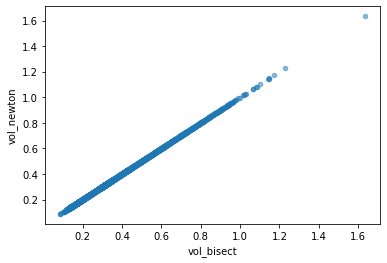

In [53]:
data_1.plot.scatter(x='vol_bisect', y='vol_newton', alpha=0.5)

In [54]:
data_1.groupby(['ticker', 'strike', 'maturity', 'type'])[['vol_bisect', 'vol_newton']].mean()

vol_bisect  vol_newton
ticker strike maturity   type                        
AMZN   1460.0 2021-03-19 call    3.030417         NaN
                         put     1.010442         NaN
              2021-04-16 call    1.309761         NaN
                         put     0.711408    0.711408
       1480.0 2021-03-19 call    2.429952         NaN
...                                   ...         ...
SPY    515.0  2021-04-16 call    0.240540    0.240542
              2021-05-21 call    0.204613    0.204613
       520.0  2021-05-21 call    0.207262    0.207262
       525.0  2021-05-21 call    0.216875    0.216874
       530.0  2021-05-21 call    0.222889    0.222888

[5091 rows x 2 columns]

## TODO: comparar com VIX e ver o que ele pediu quando mexe os strikes

## (Exercise 9)
$$C(t) - P(t) = S(t) - K e^{-r(T-t)}$$

In [55]:
# get put price from call price
data_1.loc[data_1['type'] == 'call','parity_price'] = data_1['option_price'] - data_1['Close'] + data_1['strike']*np.exp(-r * data_1['time_to_maturity'])
# get call price from put price
data_1.loc[data_1['type'] == 'put','parity_price'] = data_1['option_price'] + data_1['Close'] - data_1['strike']*np.exp(-r * data_1['time_to_maturity'])

In [56]:
data_1.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,...,time_to_maturity,day_identifier,ticker,Close,Volume,option_price,vol_bisect,price_bs,vol_newton,parity_price
0,SPY210301C00210000,2021-02-05 15:19:26,210.0,176.62,176.9,177.58,0.0,0.0,24.0,24.0,...,0.016667,DATA_1,SPY,387.029999,60629498,177.24,1.986845,177.239999,NaN,0.207551
1,SPY210301C00220000,2021-01-29 14:36:32,220.0,154.46,166.9,167.60,0.0,0.0,1.0,0.0,...,0.016667,DATA_1,SPY,387.029999,60629498,167.25,1.858901,167.250000,NaN,0.217435
2,SPY210301C00295000,2021-01-25 14:30:00,295.0,89.82,92.2,92.30,0.0,0.0,3.0,3.0,...,0.016667,DATA_1,SPY,387.029999,60629498,92.25,0.964339,92.250001,0.964341,0.216560
3,SPY210301C00300000,2021-02-02 15:52:08,300.0,82.51,87.2,87.30,0.0,0.0,1.0,10.0,...,0.016667,DATA_1,SPY,387.029999,60629498,87.25,0.911661,87.250001,0.911661,0.216501
4,SPY210301C00305000,2021-02-19 15:02:17,305.0,87.12,82.2,82.30,0.0,0.0,1.0,21.0,...,0.016667,DATA_1,SPY,387.029999,60629498,82.25,0.859593,82.250000,0.859593,0.216443


In [57]:
parity_check = data_1[['strike', 'bid', 'ask', 'maturity', 'ticker', 'option_price', 'type', 'parity_price']]
parity_check = parity_check.rename({'type': 'original_type'}, axis=1)
parity_check['parity_type'] = parity_check['original_type'].map({'call': 'put', 'put': 'call'})

In [58]:
parity_check = parity_check.drop(['bid', 'ask'], axis=1).\
    merge(parity_check.drop(['parity_price', 'parity_type', 'option_price'], axis=1),
    left_on=['strike', 'maturity', 'ticker', 'parity_type'],
    right_on=['strike', 'maturity', 'ticker', 'original_type'],
    how='left').drop('original_type_y', axis=1).dropna()

In [59]:
parity_check.sample(40).head()

,strike,maturity,ticker,option_price,original_type_x,parity_price,parity_type,bid,ask
2390,362.0,2021-03-31,SPY,3.900,put,28.955338,call,28.46,28.59
748,407.0,2021-03-08,SPY,19.840,put,-0.119713,call,0.09,0.10
3161,276.0,2021-05-21,SPY,1.635,put,112.711685,call,112.00,112.46
3273,388.0,2021-05-21,SPY,16.395,put,15.490630,call,14.60,14.68
200,347.0,2021-03-03,SPY,40.445,call,0.409603,put,0.19,0.20


In [60]:
### ADICIONAR COMENTARIO

## (Exercise 10)

In [61]:
import matplotlib.pyplot as plt

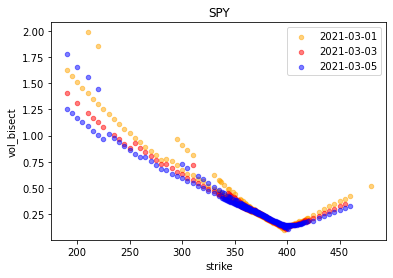

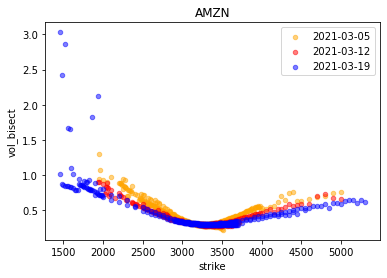

In [62]:
for ticker in data_1['ticker'].unique():
    
    fig, ax = plt.subplots()
    ax.set_title(ticker)
    aux = data_1[data_1['ticker'] == ticker]
    shortest_maturities = sorted(list(set(aux['time_to_maturity'])))[:3]
    
    for color, maturity in zip(['orange', 'red', 'blue'], shortest_maturities):
        aux2 = aux[aux['time_to_maturity'] == maturity]
        maturity_str = aux2['maturity'].iloc[0]
        
        aux2.plot.scatter(x='strike', y='vol_bisect', ax=ax, c=color, alpha=0.5, label=maturity_str)


## Exercise 11: TODO

**Vega** is already calculated above:
$$\mathrm{vega} = S  N'(d_1)  \sqrt{T-t}$$

**Delta**:
$$\Delta = N(d_1) \quad\mbox{(call)}$$
$$\Delta = N(d_1)-1 \quad\mbox{(put)}$$

**Gamma**:
$$\Gamma = \frac{1}{S \sigma \sqrt{T-t}} N'(d_1)$$

In [63]:
def bsm_delta(option_type, S, K, T, r, sigma):
    N = lambda x: stats.norm.cdf(x, loc=0.0, scale=1.0)
    d1 = 1 if T == 0 else (np.log(S/K) + (r  + sigma**2/2)*T)/(sigma*np.sqrt(T))
    extra = 0 if option_type == 'call' else -1
    
    return N(d1) + extra

def bsm_gamma(S, K, T, r, sigma):
    N_prime = lambda x: stats.norm.pdf(x, loc=0.0, scale=1.0)
    d1 = 1 if T == 0 else (np.log(S/K) + (r  + sigma**2/2)*T)/(sigma*np.sqrt(T))
    
    return 1.0/(S * sigma * np.sqrt(T)) * N_prime(d1)

In [64]:
greeks = data_1.dropna()

In [65]:
greeks['vega'] = greeks.apply(lambda x: bsm_vega(S=x['Close'], K=x['strike'], T=x['time_to_maturity'], r=r, sigma=x['vol_bisect']), axis=1)
greeks['delta'] = greeks.apply(lambda x: bsm_delta(option_type=x['type'], S=x['Close'], K=x['strike'], T=x['time_to_maturity'], r=r, sigma=x['vol_bisect']), axis=1)
greeks['gamma'] = greeks.apply(lambda x: bsm_gamma(S=x['Close'], K=x['strike'], T=x['time_to_maturity'], r=r, sigma=x['vol_bisect']), axis=1)

In [66]:
greeks[['ticker', 'type', 'Close', 'strike', 'maturity', 'option_price', 'vol_bisect', 'vega', 'delta', 'gamma']].sample(10)

,ticker,type,Close,strike,maturity,option_price,vol_bisect,vega,delta,gamma
4554,AMZN,put,3180.739990,3140.0,2021-03-19,79.900,0.304210,320.890537,-0.419182,0.001564
3695,AMZN,call,3180.739990,2920.0,2021-03-05,272.225,0.419980,95.957102,0.895659,0.000813
4694,AMZN,call,3180.739990,3090.0,2021-03-26,168.250,0.319499,349.472375,0.639164,0.001256
4840,AMZN,put,3180.739990,3130.0,2021-03-26,90.325,0.308690,363.180595,-0.411580,0.001350
1897,SPY,call,387.029999,391.0,2021-03-26,5.855,0.168379,44.575925,0.428334,0.020524
1651,SPY,put,387.029999,308.0,2021-03-19,0.345,0.444571,4.900049,-0.020301,0.001104
396,SPY,call,387.029999,362.0,2021-03-05,26.040,0.320146,11.342191,0.899738,0.008515
4492,AMZN,put,3180.739990,1840.0,2021-03-19,0.625,0.800641,7.441463,-0.002968,0.000014
4095,AMZN,call,3180.739990,3445.0,2021-03-12,13.650,0.315108,145.491294,0.129067,0.000966
2307,SPY,put,387.029999,279.0,2021-03-31,0.305,0.487206,4.324437,-0.013839,0.000593


**Numerical approximation**:
$$\frac{\partial C}{\partial S} \approx \frac{C(S+\delta) - C(S-\delta)}{2\delta}$$
$$\frac{\partial^2 C}{\partial S^2} \approx \frac{C(S+\delta) - 2 C(S) + C(S-\delta)}{\delta^2}$$

In [67]:
# using the values below for the numerical differences
delta_vol = 0.01
delta_spot = 10

In [68]:
greeks['vega_approx'] = (greeks.apply(lambda x: bsm_value(x['type'], x['Close'], x['strike'], x['time_to_maturity'], r,
                                                         x['vol_bisect'] + delta_vol), axis=1)
                        - greeks.apply(lambda x: bsm_value(x['type'], x['Close'], x['strike'], x['time_to_maturity'], r,
                                                         x['vol_bisect'] - delta_vol), axis=1)
                        )/2*delta_vol

greeks['delta_approx'] = (greeks.apply(lambda x: bsm_value(x['type'], x['Close']+delta_spot,
                                                           x['strike'], x['time_to_maturity'], r, x['vol_bisect']), axis=1)
                        - greeks.apply(lambda x: bsm_value(x['type'], x['Close']-delta_spot, 
                                                           x['strike'], x['time_to_maturity'], r, x['vol_bisect']), axis=1)
                        )/2*delta_spot

greeks['gamma_approx'] = (greeks.apply(lambda x: bsm_value(x['type'], x['Close']+delta_spot,
                                                           x['strike'], x['time_to_maturity'], r, x['vol_bisect']), axis=1)
                        - 2*greeks.apply(lambda x: bsm_value(x['type'], x['Close'], 
                                                           x['strike'], x['time_to_maturity'], r, x['vol_bisect']), axis=1)
                        + greeks.apply(lambda x: bsm_value(x['type'], x['Close']-delta_spot, 
                                                           x['strike'], x['time_to_maturity'], r, x['vol_bisect']), axis=1)
                        )/(delta_spot)**2

Plotting to check how similar they are:

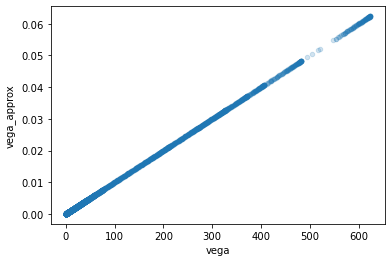

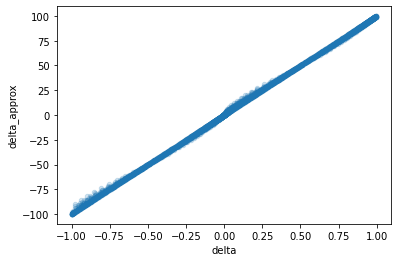

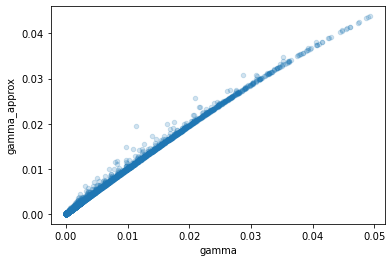

In [69]:
for greek in ['vega', 'delta', 'gamma']:
    greeks.plot.scatter(x=greek, y=f'{greek}_approx', alpha=0.2)

## Exercise 12

In [70]:
data_2 = options[(options['day_identifier'] == 'DATA_2') & (options['ticker'] != '^VIX')]

In [71]:
data_2 = data_2.merge(data_1.dropna()[['contractSymbol', 'vol_bisect']], how='inner')

In [72]:
data_2['calculated_price'] = data_2.apply(lambda row: bsm_value(row['type'], row['Close'], row['strike'], row['time_to_maturity'], r, row['vol_bisect']), axis=1)

Save for future use

In [73]:
data_2.to_csv('%doctest_mode2/data_2.csv')

<AxesSubplot:xlabel='option_price', ylabel='calculated_price'>

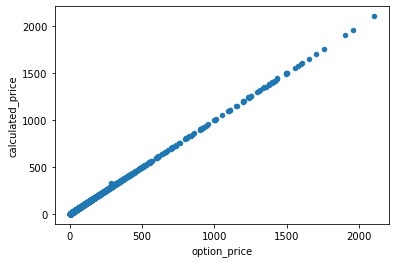

In [361]:
data_2[['option_price', 'calculated_price']].plot.scatter(x='option_price', y='calculated_price')

# (Part 3) - Numerical Integration

1 - (a) Trapezoidal Method

In [386]:
from math import sin, e, pi

In [387]:
#function f(x) = sin(x)/x

def f(x):
    if x !=0:
        return sin(x)/x
    if x ==0:
        return 1

In [404]:
def Trapezoidal (f,a,b,N):
    h = (b-a)/N
    s = 0.5*f(a) + 0.5*f(b)

    for k in (range(1,N)):
        s+= f(a+k*h)

    return h*s

In [405]:
integral_trap = Trapezoidal(f, -10**4, 10**4, 100000)
integral_trap

3.141782455598503

In [406]:
erro_trap = integral_trap - pi
erro_trap

0.00018980200870988284

1 - (b) Simpson's Method

In [407]:
def Simpson(f, a, b, n):
   
    h = (b - a) / n
    k = 0
    z = 0

    for i in (range(1, n // 2)):
        k += 2 * f(a + 2 * i * h)

    for i in (range(1, n // 2 + 1)):
        z += 4 * f(a + (2 * i - 1) * h)

    return h * (f(a) + k + z + f(b)) / 3.0

In [408]:
integral_simp = Simpson(f, -10**5, 10**5, 1000000)
integral_simp

3.1416126409773426

In [409]:
erro_simp = integral_simp - pi
erro_simp

1.9987387549491586e-05

2 - Truncation Error

In [443]:
def truncation_error(f, int_method, a, N):
    integration = int_method(f, -a, a, N)
    error = np.abs(integration - pi)
    return error

In [444]:
from itertools import product

In [445]:
a_range = [100, 500, 1000, 5000, 10000]
N_range = range(10000, 1000000, 100000)

In [446]:
error = np.zeros((len(a_range), len(N_range)))

In [447]:
for i, a in enumerate(a_range):
    for j, N in enumerate(N_range):
        error[i][j] = truncation_error(f, Trapezoidal, a, N)

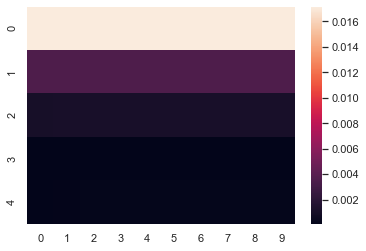

In [449]:
import seaborn as sns; sns.set_theme()
ax = sns.heatmap(error)

Very little sensitivity to $N$ (horizontal axis); for a given $a$, convergence is pretty fast for sufficiently high $N$

3 - Convergence

In [466]:
n_list = range(10,10000,10)

For trapezoidal:

In [467]:
trap_iters = pd.DataFrame({'n': n_list,
                           'int': [Trapezoidal(f, -10**4, 10**4, n) for n in tqdm(n_list)]})

In [469]:
trap_iters['error'] = np.abs(trap_iters['int'] - trap_iters['int'].shift(1))
trap_iters['log_error'] = np.log10(trap_iters['error'])

Show where error becomes smaller than 10-4, or in log scale, <-4:

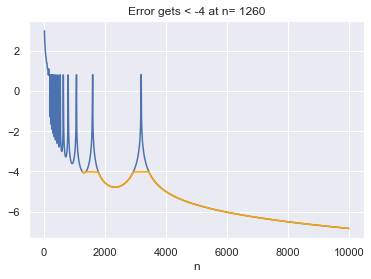

In [478]:
aux = trap_iters.set_index('n')['log_error']
aux.plot()
aux[aux<-4].plot(color='orange')
plt.title(f"Error gets < -4 at n= {aux[aux<-4].head(1).index[0]}")
plt.show()

For Simpson:

In [479]:
simps_iters = pd.DataFrame({'n': n_list,
                           'int': [Simpson(f, -10**4, 10**4, n) for n in tqdm(n_list)]})

In [480]:
simps_iters['error'] = np.abs(simps_iters['int'] - simps_iters['int'].shift(1))
simps_iters['log_error'] = np.log10(simps_iters['error'])

Show where error becomes smaller than 10-4, or in log scale, <-4:

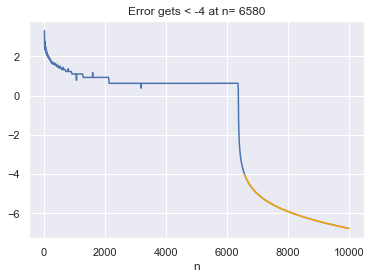

In [481]:
aux = simps_iters.set_index('n')['log_error']
aux.plot()
aux[aux<-4].plot(color='orange')
plt.title(f"Error gets < -4 at n= {aux[aux<-4].head(1).index[0]}")
plt.show()

We see that the trapezoidal method oscillates but converges faster, whereas Simpson has a monotnic decrease in error but converges at higher values of $n$

4 - g(x)

In [482]:
TOL = 1e-4

In [484]:
#function g(x) = 1 + e^(-x^2)*sin(8x^(2/3))

def g(x):
    return (1 + (e**(-x**2))*sin(8*(x**(2/3))))

In [528]:
def integrate(g, method):
    i0 = 0.01
    for n in range(1,100000,10000):
        i1 = method(g, 0, 2, n)
        error = np.abs((i1-i0)/i0)
        if error < TOL:
            break
        else:
            i0 = i1

    return round(i1,4)

In [529]:
integrate(g, Trapezoidal)

2.0375

In [530]:
integrate(g, Simpson)

2.0374